# Where can you get the Cheapest 3 Bed Flat Apartments in Lagos?

In [1]:
import requests
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from time import sleep
from random import randint

# Data Extraction from (www.propertypro.ng)

In [ ]:
pages = np.arange(0,2000,1)

In [ ]:
title = []
price = []
location = []
category = []
subtitle = []
description = []
currency = []
other_details = []
amenity = []

In [ ]:
for page_num in pages:

    page = requests.get("https://www.propertypro.ng/property-for-rent/in/lagos?page=" + str(page_num))
                        
    soup = BeautifulSoup(page.text,'html.parser')
    properties = soup.find_all('div', class_="single-room-text")
                        
    sleep (randint(2,10))
                        
    for container in properties:
        titles = container.a.find("h2", class_="listings-property-title").text
        title.append(titles)
        
        subtitles = container.find("h3", class_="listings-property-title2").text
        subtitle.append(subtitles)
        
        currencys = container.find("span", itemprop="priceCurrency").text
        currency.append(currencys)
        
        prices = container.find("span", itemprop="price").text.split('/')[0].replace(",","")
        price.append(prices)
                                  
        locations = container.find("h4").text
        location.append(locations)
        
        categorys = container.find_all("div", {"class","furnished-btn"})[0].text.replace("\n"," ").strip()
        category.append(categorys)
                            
       
        otherdetails = container.find("p", class_="d-none d-sm-block").text
        other_details.append(otherdetails)
        
        amenitys = container.find_all("div", {"class":"fur-areea"})[0].text.replace(" ","").replace("\n"," ").strip()
        amenity.append(amenitys)
        
        descriptions = container.find("h3", class_="listings-property-title2").text
        description.append(descriptions)

In [ ]:
df = pd.DataFrame({"title":title, "subtitle": subtitle, "location": location,\
                   "category": category,"amenity": amenity,\
                   "currency": currency, "price":price, "description": description,\
                   "other_details": other_details})
df["price"] = df["price"].astype(int)
df.to_csv('house_rent_price_in_lagos.csv')

#### To save our time, we store the extracted data to our desktop. It took over 5 hours to scrap the 2000 pages of data from the Propertypro website. We can't be running the scraping code all the time.
#### This data was scraped on the 2nd of April, 2021.

# Data Cleaning

In [2]:
rent = pd.read_csv("house_rent_price_in_lagos.csv")
rent.head(3)

,Unnamed: 0,title,subtitle,location,category,amenity,currency,price,description,other_details
0,0,3 BEDROOM TERRACED DUPLEX HOUSE FOR RENT,Luxury 3 Bedroom Terrace Duplex with B/Q Servi...,Horizon 2 Extension EstateIkate Lekki Lagos,Serviced Newly Built,3beds 3baths 4Toilets,₦,3750000,Luxury 3 Bedroom Terrace Duplex with B/Q Servi...,FOR RENT: Luxury 3 Bedroom Terrace Duplex Wit...
1,1,4 BEDROOM SEMI DETACHED DUPLEX HOUSE FOR RENT,VERY PRACTICAL / CENTRALLY LOCATED 4 BEDROOM S...,OFF AHMADU BELLO WAYAhmadu Bello Way Victoria ...,Serviced,4beds 4baths 5Toilets,₦,5000000,VERY PRACTICAL / CENTRALLY LOCATED 4 BEDROOM S...,FOR RENT: *************STRICTLY FOR DIRECT CL...
2,2,3 BEDROOM FLAT / APARTMENT FOR RENT,PRINCE ADEMOLA OSINUGA EXCLUSIVE 12NOS CENTRAL...,CENTRAL IKOYIOld Ikoyi Ikoyi Lagos,Serviced,3beds 3baths 4Toilets,₦,74400000,PRINCE ADEMOLA OSINUGA EXCLUSIVE 12NOS CENTRAL...,FOR RENT: ******STRICTLY FOR DIRECT & CASH RE...


In [3]:
#We have about 50,000 properties in the dataset

rent.shape 

(57918, 10)

#### Dropping unwanted columns (Unnamed: 0 and category)

In [4]:
rent.drop(['Unnamed: 0','category'], axis = 1, inplace=True)

#### Splittng the amenity column into bed,bath, and toilet, then deleting the amenity column afterwards

In [5]:
rent[['bed','bath','toilet']] = rent['amenity'].str.split(" ", expand=True)
rent['bed'] = rent['bed'].str.replace('beds','')
rent['bath'] = rent['bath'].str.replace('baths','')
rent['toilet'] = rent['toilet'].str.replace('Toilets','')
rent.drop('amenity', axis = 1, inplace=True)
rent.head(3)

,title,subtitle,location,currency,price,description,other_details,bed,bath,toilet
0,3 BEDROOM TERRACED DUPLEX HOUSE FOR RENT,Luxury 3 Bedroom Terrace Duplex with B/Q Servi...,Horizon 2 Extension EstateIkate Lekki Lagos,₦,3750000,Luxury 3 Bedroom Terrace Duplex with B/Q Servi...,FOR RENT: Luxury 3 Bedroom Terrace Duplex Wit...,3,3,4
1,4 BEDROOM SEMI DETACHED DUPLEX HOUSE FOR RENT,VERY PRACTICAL / CENTRALLY LOCATED 4 BEDROOM S...,OFF AHMADU BELLO WAYAhmadu Bello Way Victoria ...,₦,5000000,VERY PRACTICAL / CENTRALLY LOCATED 4 BEDROOM S...,FOR RENT: *************STRICTLY FOR DIRECT CL...,4,4,5
2,3 BEDROOM FLAT / APARTMENT FOR RENT,PRINCE ADEMOLA OSINUGA EXCLUSIVE 12NOS CENTRAL...,CENTRAL IKOYIOld Ikoyi Ikoyi Lagos,₦,74400000,PRINCE ADEMOLA OSINUGA EXCLUSIVE 12NOS CENTRAL...,FOR RENT: ******STRICTLY FOR DIRECT & CASH RE...,3,3,4


#### Dropping some properties for sale which were included in the scrapped data

In [6]:
sale = rent[rent['other_details'].str.contains('SALE')].index
rent = rent.drop(sale)

#### Staying away from some inconsistency in the currency, and issues of currency version, we are taking away properties quoted in dollars

In [7]:
rent['currency'] = rent['currency'].replace({'₦':'naira','$':'dollars'})
prop_in_dollars = rent[rent['currency']=='dollars'].index
rent = rent.drop(prop_in_dollars)

#### Trying to extract the exact areas from the property addresses in the location column. Not really giving us what we want, but we will sort this later

In [8]:
rent['area'] = rent['location'].str.split(" ").str[-2]
rent['area'].unique()

array(['Lekki', 'Island', 'Ikoyi', 'Gbagada', 'Ikeja', 'Surulere',
       'Ojodu', '-Ikoyi', 'Maryland', 'Yaba', 'Ajah', 'LekkiLekki',
       'Apapa', 'Isolo', 'Okota', 'Ogba', 'Agege', 'Right.Lekki', 'Ipaja',
       'OrchidLekki', 'TollgateLekki', 'RoadLekki', 'Marwa,Lekki',
       'gateLekki', 'shopriteIkeja', 'ChevronLekki', 'right.Lekki',
       'rightLekki', 'tollgateLekki', 'roadLekki', 'Idimu', 'estateIkoyi',
       'AjahLekki', 'roadIkoyi', 'Ilupeju', 'OsapaLekki', 'ComplexAjah',
       'Ogudu', 'IkoyiIkoyi', 'GateLekki', 'driveLekki', 'EstateLekki',
       'SangotedoAjah', 'Egba', 'Odofin', 'Island.Ikoyi', 'BucknorIsolo',
       'EjigboEjigbo', 'orchidLekki', 'Ejigbo', 'stopEjigbo',
       'estateLekki', 'Igando', '1Lekki', 'Shomolu', 'GRAIkeja',
       'yabaYaba', 'RoadIkoyi', 'Iju', 'KetuKetu', 'Ikosi', 'Ketu',
       '-Ketu', '-Gbagada', 'KiloSurulere', 'Lagos.Yaba',
       'EstateSangotedo', 'Yaba.Yaba', 'WaterprimeLekki', 'Ikorodu',
       'isoloIsolo', 'GRAYaba', 'rdShom

#### Taking away some of the properties we don't want included in our data, such as Land, School, Hotel etc

In [9]:
unwanted_props = rent[rent['title'].str.contains('LAND|EVENT CENTRE|BLOCKS OF FLAT|CHURCH|BEDROOM HOUSE|\
                                                 SCHOOL|SHORTLET|FACTORY|COMMERCIAL PROPERTY|HOTEL|GUEST|FARM|SHOW|\
                                                 ')].index

In [10]:
rent = rent.drop(unwanted_props)
rent.shape

(44928, 11)

#### Taking away same properties that were repeated

In [11]:
rent.drop_duplicates(inplace = True)

In [12]:
rent['title'].unique()

array(['3 BEDROOM TERRACED DUPLEX HOUSE FOR RENT',
       '4 BEDROOM SEMI DETACHED DUPLEX HOUSE FOR RENT',
       '3 BEDROOM FLAT / APARTMENT FOR RENT',
       '2 BEDROOM FLAT / APARTMENT FOR RENT',
       '5 BEDROOM DETACHED DUPLEX HOUSE FOR RENT',
       '4 BEDROOM TERRACED DUPLEX HOUSE FOR RENT',
       '3 BEDROOM MASSIONETTE HOUSE FOR RENT',
       '4 BEDROOM FLAT / APARTMENT FOR RENT',
       '4 BEDROOM MASSIONETTE HOUSE FOR RENT',
       '3 BEDROOM SEMI DETACHED DUPLEX HOUSE FOR RENT',
       '4 BEDROOM DETACHED DUPLEX HOUSE FOR RENT',
       '5 BEDROOM SEMI DETACHED DUPLEX HOUSE FOR RENT',
       '2 BEDROOM MINI FLAT FLAT / APARTMENT FOR RENT',
       '3 BEDROOM MINI FLAT FLAT / APARTMENT FOR RENT',
       '3 BEDROOM DETACHED BUNGALOW HOUSE FOR RENT',
       '6 BEDROOM DETACHED DUPLEX HOUSE FOR RENT',
       '1 BEDROOM MINI FLAT FLAT / APARTMENT FOR RENT',
       '1 BEDROOM MINI FLAT MINI FLAT FLAT / APARTMENT FOR RENT',
       '4 BEDROOM PENTHOUSE FLAT / APARTMENT FOR RENT',
  

#### Assigning a uniformed name to each property in the data

In [13]:
conditions = [
    (rent['title'].str.contains('DUPLEX')),
    (rent['title'].str.contains('BEDROOM FLAT')),
    (rent['title'].str.contains('SHOP')),
    (rent['title'].str.contains('OFFICE')),
    (rent['title'].str.contains('MASSIONETTE')),
    (rent['title'].str.contains('PENTHOUSE')),
    (rent['title'].str.contains('BUNGALOW')),
    (rent['title'].str.contains('SHARED')),
    (rent['title'].str.contains('STUDIO')),
    (rent['title'].str.contains('BOYS')),
    (rent['title'].str.contains('WORKING')),
    (rent['title'].str.contains('WAREHOUSE')),
    (rent['title'].str.contains('SELF CONTAIN')),
    (rent['title'].str.contains('DETACHED HOUSE')),
    (rent['title'].str.contains('MINI FLAT FLAT')),
    (rent['title'].str.contains('BEDROOM BLOCK')),
    (rent['title'].str.contains('BLOCK OF FLAT')),
    (rent['title'] == 'FLAT / APARTMENT FOR RENT'),
    (rent['title'] == 'HOUSE FOR RENT'),
    (rent['title'].str.contains('BEDROOM MINI FLAT HOUSE')),
    (rent['title'].str.contains('BEDROOM TERRACE FOR RENT')),
    (rent['title'].str.contains('MINI FLAT FACE'))
    
]

values = ['Duplex','Flat','Shop','Office Space','Masionette','Penthouse','Bungalow','Shared Apartment',
         'Studio Apartment','BQ Flat','Office Space','Warehouse','Self Contain','Duplex','Mini Flat','Flat',
         'Flat','Flat','Others not specified','Mini Flat','Duplex','Mini Flat']

In [14]:
rent['prop_type'] = np.select(conditions,values)
rent['prop_type'].unique()

array(['Duplex', 'Flat', 'Masionette', 'Mini Flat', 'Bungalow',
       'Penthouse', 'Self Contain', 'Shared Apartment',
       'Studio Apartment', 'BQ Flat', 'Office Space',
       'Others not specified'], dtype=object)

In [15]:
rent.reset_index(drop = True, inplace = True)

#### After extracting the areas from the location column, the area column still looks dirty, inconsistent, and not good enough for analysis. Example is having (',lekkilekki', 'estate') and so on.
#### So we are exporting the location and area data to excel to do a proper assignment of areas to the different locations.

In [16]:
location = rent[['location','area']]
location.to_csv('location.csv')

#### We have done the proper assignment of each location and we have named the file 'location_match
#### This gives us a clean data of the area of each property

In [17]:
location_match = pd.read_csv("location match csv.csv")

In [18]:
location_match.head()

,location,match
0,Horizon 2 Extension EstateIkate Lekki Lagos,Ikate Lekki
1,OFF AHMADU BELLO WAYAhmadu Bello Way Victoria ...,Victoria Island
2,CENTRAL IKOYIOld Ikoyi Ikoyi Lagos,Old Ikoyi
3,Oju Olobun StreetVictoria Island Lagos,Victoria Island
4,Off chief Yesufu Abiodun Oniru Victoria Island...,Victoria Island


In [19]:
location_match['match'].unique()

array(['Ikate Lekki', 'Victoria Island', 'Old Ikoyi', 'Surulere', 'Ikoyi',
       'Parkview Ikoyi', 'OPIC Ojodu', 'Banana Island Ikoyi',
       'Osbourne Ikoyi', 'Maryland', 'Ebute Metta Yaba', 'Sangotedo Ajah',
       'Ikota Lekki', 'Lekki', 'Ajah', 'GRA Ikeja', 'Phase 1 Lekki',
       'Ifako Gbagada', 'Phase 1 Gbagada', 'Abijo Ajah', 'Fagba',
       'Chevron Lekki', 'Sabo Yaba', 'Alagomeji Yaba', 'Lekki Right',
       'Gbagada', 'Baruwa Ipaja', 'Ipaja', 'Second Tollgate Lekki',
       'Jakande Lekki', 'Marwa Lekki', 'Idado Lekki', 'Alausa Ikeja',
       'Osapa London Lekki', 'Iponri Surulere', 'Ojodu', 'Lawanson',
       'Soluyi Gbagada', 'Awoyaya Ajah', 'Lakowe Ajah', 'Idimu',
       'Nicon Town Lekki', 'Ilasan Lekki', 'Agungi Lekki', 'Iwaya Yaba',
       'VGC Lekki', 'Anthony Village', 'GRA Ogudu', 'Ologolo Lekki',
       'Kajola Lekki', 'Lekki Gardens', 'Adeniyi Jones Ikeja', 'Yaba',
       'Ilaje Ajah', 'Bucknor Isolo', 'Oke Afa Isolo', 'Ago Palace Okota',
       'Okota', 'Ajao E

#### Joining our new data file, to the original data, so that each location can get the proper area label

In [20]:
merged = rent.merge(location_match, how = 'left', left_index = True, right_index = True)

#### We late discovered the Itele and Ayetoro are not in Lagos, so we are taking the areas out

In [21]:
iteleandayetoro = merged[merged['match'].isin(['Itele', 'Ayetoro'])].index

In [22]:
merged = merged.drop(iteleandayetoro)

#### Taking away properties having as price as 0,1,4, 10 up to 150,000
#### We are taking away prices up 150,000 because some of the properties with that price look ambigious. For instance a 3 bed flat for 150k in Lekki, something not even obtainable in low-income areas of lagos. And morevoer, it is not clear or stated if the amount is per month. Apart from all this, we believe all other prices are annual based

In [23]:
pricesbelow150k = merged[merged['price'] <= 150000].index
merged = merged.drop(pricesbelow150k)

In [25]:
merged.reset_index(drop = True, inplace = True)

#### Categorising each property for analysis

In [27]:
conditions = [
    (merged['price'] <= 500000),
    (merged['price'] <= 1000000),
    (merged['price'] <= 2000000),
    (merged['price'] <= 5000000),
    (merged['price'] > 5000000)
]

values = ['Less than 500k', '501k-1M', '1.1M-2M', '2.1M-5M', 'Above 5M']

In [28]:
merged['pricerange'] = np.select(conditions,values)

# Focus on 3 Bed Flat Apartments

In [29]:
threebedflat = merged[(merged['prop_type'] == 'Flat') & (merged['bed'] == '3')]
cheapest3bedflats = threebedflat.nsmallest(10, 'price')

In [30]:
avgpriceof3bedflat = threebedflat.groupby('match').mean()

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

# Where can you get the Cheapest 3 Bed Flat Apartment

Text(0.5, 1.0, 'Areas with Cheapest 3 Bedroom Flats in Lagos')

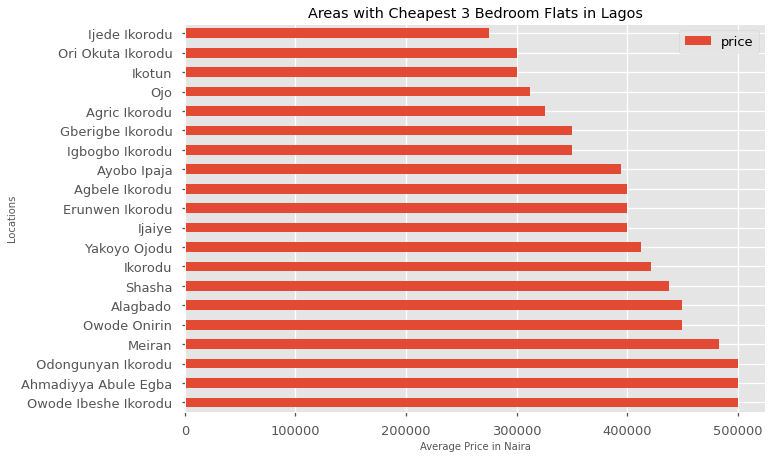

In [33]:
plt.style.use('ggplot')
below500k = avgpriceof3bedflat.nsmallest(20, 'price').sort_values('price', ascending = False)
below500k.plot(kind = 'barh')
plt.xlabel('Average Price in Naira', size = 10)
plt.ylabel('Locations', size = 10)
plt.title('Areas with Cheapest 3 Bedroom Flats in Lagos')

# What if you decided to extend your budget to 1million naira
# Which areas can you settle in?

Text(0.5, 1.0, 'Areas with 3 Bedroom Flats Between 501k and 1 million')

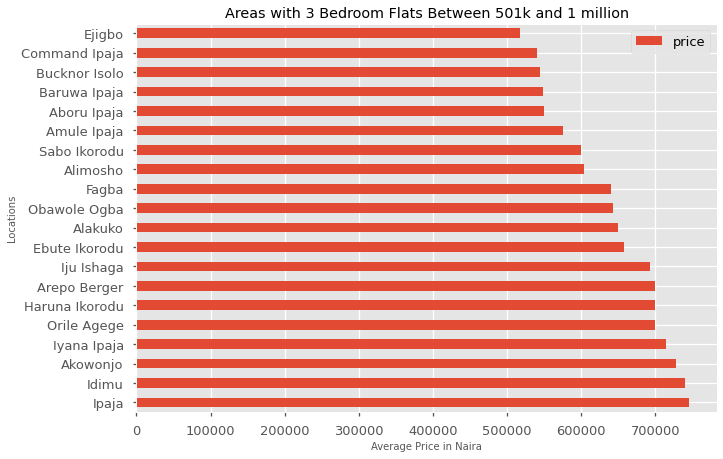

In [34]:
btw500and1m = avgpriceof3bedflat[avgpriceof3bedflat['price'].between(501000,1000000)].nsmallest(20,'price').sort_values('price', ascending=False)
btw500and1m.plot(kind = 'barh')
plt.xlabel('Average Price in Naira', size = 10)
plt.ylabel('Locations', size = 10)
plt.title('Areas with 3 Bedroom Flats Between 501k and 1 million')